# Rag From Scratch: Indexing

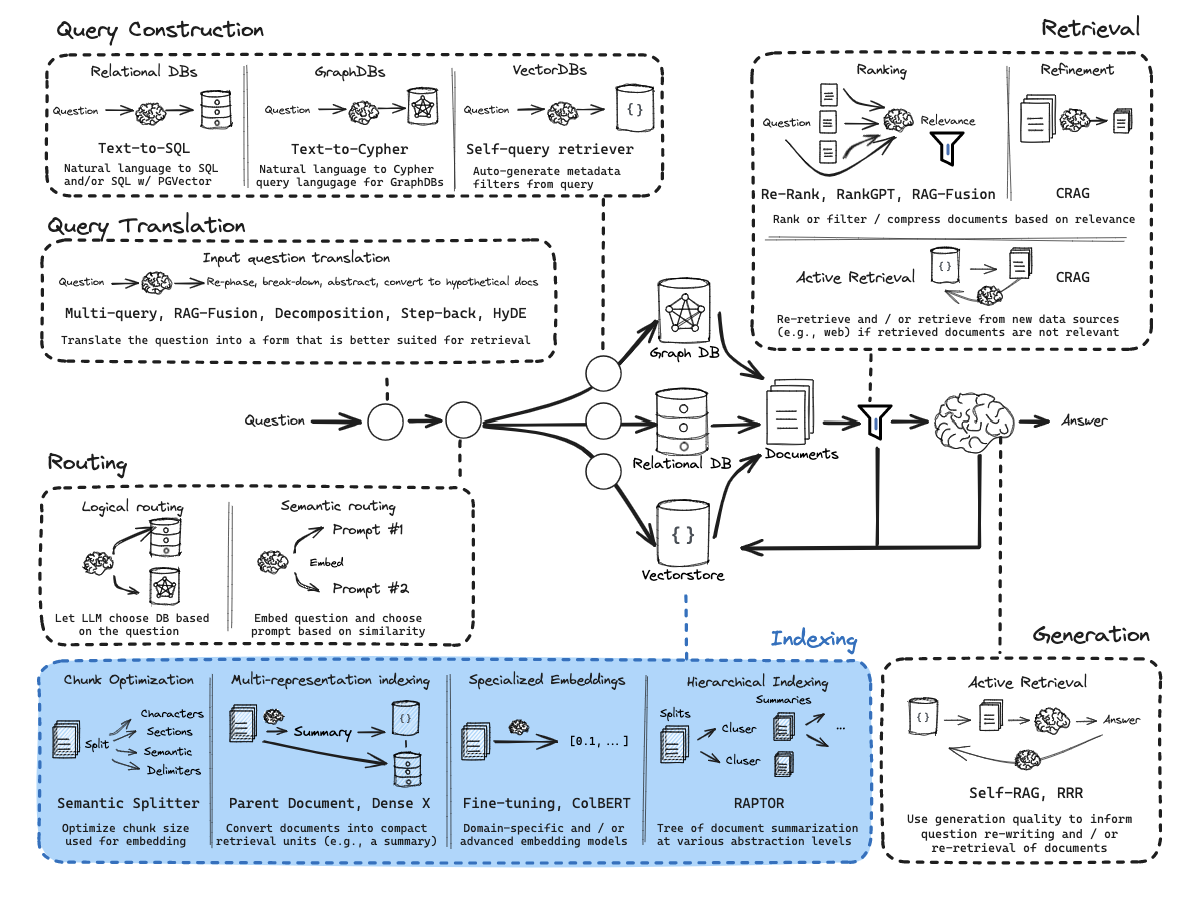

## Preface: Chunking

We don't explicity cover document chunking / splitting.

For an excellent review of document chunking, see this video from Greg Kamradt:

https://www.youtube.com/watch?v=8OJC21T2SL4

## Enviornment

`(1) Packages`

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube

`(2) LangSmith`

https://docs.smith.langchain.com/

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

`(3) API Keys`

In [ ]:
os.environ['OPENAI_API_KEY'] = <your-api-key>

## Part 12: Multi-representation Indexing

Flow: 

 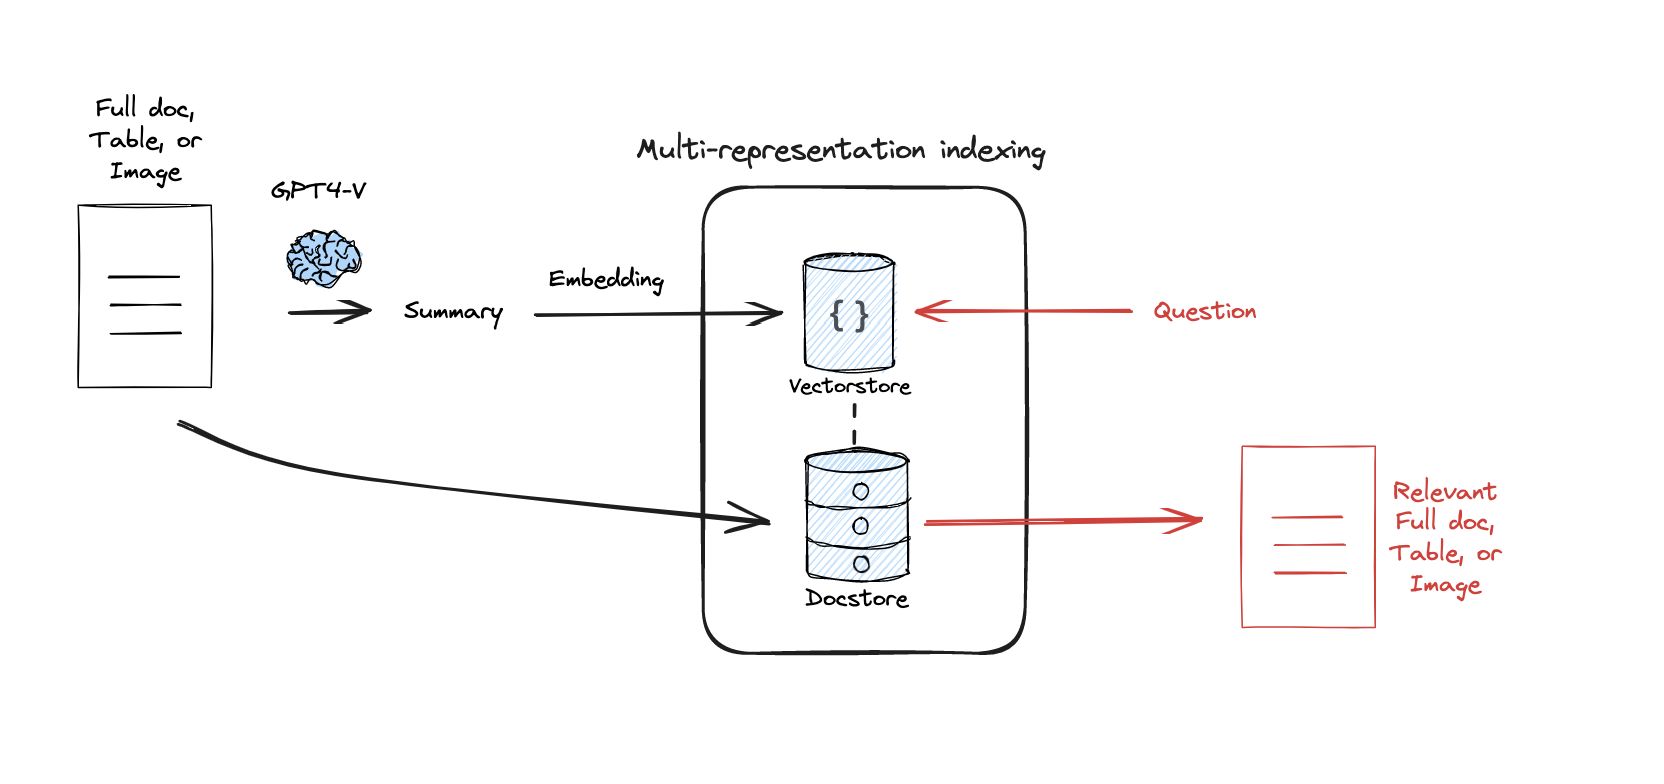

Docs:

https://blog.langchain.dev/semi-structured-multi-modal-rag/

https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector

Paper:

https://arxiv.org/abs/2312.06648

In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [2]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(model="gpt-3.5-turbo",max_retries=0)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [4]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [5]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(page_content='The document discusses the concept of building autonomous agents powered by Large Language Models (LLMs) as their core controllers. It covers components such as planning, memory, and tool use, along with case studies and proof-of-concept examples like AutoGPT and GPT-Engineer. Challenges like finite context length, planning difficulties, and reliability of natural language interfaces are also highlighted. The document provides references to related research papers and offers a comprehensive overview of LLM-powered autonomous agents.', metadata={'doc_id': 'cf31524b-fe6a-4b28-a980-f5687c9460ea'})

In [6]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n"

Related idea is the [parent document retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever).

## Part 13: RAPTOR

Flow:

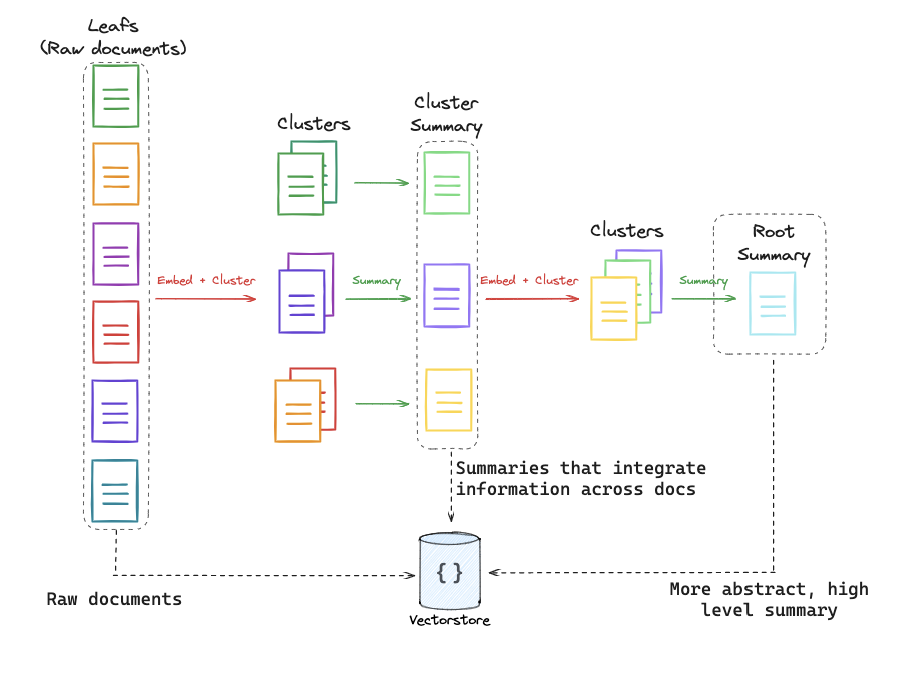

Deep dive video:

https://www.youtube.com/watch?v=jbGchdTL7d0

Paper:

https://arxiv.org/pdf/2401.18059.pdf

Full code:

https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

## Part 14: ColBERT

RAGatouille makes it as simple to use ColBERT. 

ColBERT generates a contextually influenced vector for each token in the passages. 

ColBERT similarly generates vectors for each token in the query.

Then, the score of each document is the sum of the maximum similarity of each query embedding to any of the document embeddings:

See [here](https://hackernoon.com/how-colbert-helps-developers-overcome-the-limits-of-rag) and [here](https://python.langchain.com/docs/integrations/retrievers/ragatouille) and [here](https://til.simonwillison.net/llms/colbert-ragatouille).

In [ ]:
! pip install -U ragatouille

In [9]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

[Mar 26, 15:26:45] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [10]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [11]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Mar 26, 15:27:19] #> Note: Output directory .ragatouille/colbert/indexes/Miyazaki-123 already exists


[Mar 26, 15:27:19] #> Will delete 10 files already at .ragatouille/colbert/indexes/Miyazaki-123 in 20 seconds...
[Mar 26, 15:27:40] [0] 		 #> Encoding 81 passages..


  0%|                                                               | 0/3 [00:00<?, ?it/s]/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
 33%|██████████████████▎                                    | 1/3 [00:01<00:03,  1.67s/it]/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|███████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

[Mar 26, 15:27:44] [0] 		 avg_doclen_est = 129.88888549804688 	 len(local_sample) = 81
[Mar 26, 15:27:44] [0] 		 Creating 1,024 partitions.
[Mar 26, 15:27:44] [0] 		 *Estimated* 10,520 embeddings.
[Mar 26, 15:27:44] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/Miyazaki-123/plan.json ..


used 15 iterations (0.2493s) to cluster 9995 items into 1024 clusters
[0.037, 0.041, 0.038, 0.034, 0.031, 0.037, 0.034, 0.037, 0.033, 0.034, 0.037, 0.038, 0.035, 0.037, 0.034, 0.04, 0.032, 0.032, 0.034, 0.035, 0.038, 0.039, 0.037, 0.035, 0.039, 0.032, 0.038, 0.032, 0.038, 0.035, 0.036, 0.037, 0.039, 0.033, 0.033, 0.034, 0.035, 0.032, 0.034, 0.04, 0.034, 0.038, 0.037, 0.032, 0.04, 0.035, 0.039, 0.035, 0.036, 0.037, 0.036, 0.036, 0.034, 0.039, 0.037, 0.037, 0.04, 0.038, 0.041, 0.031, 0.035, 0.034, 0.034, 0.033, 0.038, 0.038, 0.036, 0.04, 0.032, 0.032, 0.035, 0.036, 0.034, 0.035, 0.035, 0.032, 0.035, 0.038, 0.038, 0.036, 0.037, 0.039, 0.036, 0.041, 0.034, 0.037, 0.038, 0.037, 0.034, 0.04, 0.035, 0.037, 0.034, 0.035, 0.035, 0.037, 0.038, 0.037, 0.035, 0.036, 0.04, 0.039, 0.033, 0.035, 0.037, 0.035, 0.036, 0.034, 0.037, 0.036, 0.034, 0.037, 0.038, 0.032, 0.037, 0.037, 0.035, 0.036, 0.036, 0.039, 0.036, 0.035, 0.034, 0.033, 0.032, 0.037, 0.038, 0.032]


0it [00:00, ?it/s]

[Mar 26, 15:27:44] [0] 		 #> Encoding 81 passages..



100%|███████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]
1it [00:03,  3.05s/it]
100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1496.90it/s]

[Mar 26, 15:27:47] #> Optimizing IVF to store map from centroids to list of pids..
[Mar 26, 15:27:47] #> Building the emb2pid mapping..
[Mar 26, 15:27:47] len(emb2pid) = 10521



100%|█████████████████████████████████████████████| 1024/1024 [00:00<00:00, 165617.83it/s]

[Mar 26, 15:27:47] #> Saved optimized IVF to .ragatouille/colbert/indexes/Miyazaki-123/ivf.pid.pt
Done indexing!


'.ragatouille/colbert/indexes/Miyazaki-123'

In [12]:
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

Loading searcher for index Miyazaki-123 for the first time... This may take a few seconds
[Mar 26, 15:28:12] #> Loading codec...
[Mar 26, 15:28:12] #> Loading IVF...
[Mar 26, 15:28:12] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[Mar 26, 15:28:12] #> Loading doclens...


100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2646.25it/s]

[Mar 26, 15:28:12] #> Loading codes and residuals...



100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00, 388.65it/s]

[Mar 26, 15:28:12] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Mar 26, 15:28:12] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What animation studio did Miyazaki found?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  7284,  2996,  2106,  2771,  3148, 18637,  2179,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[{'content': 'In April 1984, Miyazaki opened his own office in Suginami Ward, naming it Nibariki.\n\n\n=== Studio Ghibli ===\n\n\n==== Early films (1985–1996) ====\nIn June 1985, Miyazaki, Takahata, Tokuma and Suzuki founded the animation production company Studio Ghibli, with funding from Tokuma Shoten. Studio Ghibli\'s first film, Laputa: Castle in the Sky (1986), employed the same production crew of Nausicaä. Miyazaki\'s designs for the film\'s setting were inspired by Greek architecture and "European urbanistic templates".',
  'score': 25.903671264648438,
  'rank': 1,
  'document_id': '3a949f61-e976-4fc0-a272-d7bdbe777b21',
  'passage_id': 28},
 {'content': 'Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, Japanese: [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. A co-founder of Studio Ghibli, he has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of th

In [13]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")

/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[Document(page_content='In April 1984, Miyazaki opened his own office in Suginami Ward, naming it Nibariki.\n\n\n=== Studio Ghibli ===\n\n\n==== Early films (1985–1996) ====\nIn June 1985, Miyazaki, Takahata, Tokuma and Suzuki founded the animation production company Studio Ghibli, with funding from Tokuma Shoten. Studio Ghibli\'s first film, Laputa: Castle in the Sky (1986), employed the same production crew of Nausicaä. Miyazaki\'s designs for the film\'s setting were inspired by Greek architecture and "European urbanistic templates".'),
 Document(page_content='Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, Japanese: [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. A co-founder of Studio Ghibli, he has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history of animation.\nBorn in Tokyo City in the Empire of Japa